In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psycopg2
import pandas as pd
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from dotenv import load_dotenv

load_dotenv()

pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")
pg_host = os.getenv("PG_HOST")
pg_port = os.getenv("PG_PORT")
pg_db = os.getenv("PG_DB")

In [2]:
# Cleaning the tweets
def preprocess(tweet):
    
    # remove links
    tweet = re.sub(r'http\S+', '', tweet)
    # remove mentions
    tweet = re.sub("@\w+","",tweet)
    # alphanumeric and hashtags
    tweet = re.sub("[^a-zA-Z#]"," ",tweet)
    # remove multiple spaces
    tweet = re.sub("\s+"," ",tweet)
    tweet = tweet.lower()
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    sent = ' '.join([lemmatizer.lemmatize(w) for w in tweet.split() if len(lemmatizer.lemmatize(w))>3])

    return sent   

In [3]:
# Connecting to the Database
def DbConnect(query):
    
    conn = psycopg2.connect(host=pg_host, database=pg_db, port=pg_port, user=pg_user, password=pg_password)
    curr = conn.cursor()
    
    curr.execute(query)
    
    rows = curr.fetchall()
    
    return rows

In [4]:
# Create 
data_tweet = DbConnect("SELECT User_Id, Tweet_Id, Tweet FROM TwitterTweet;")

df_tweet = pd.DataFrame(columns=['User_Id','Tweet_Id','Clean_Tweet'])

for data in data_tweet:
    index = len(df_tweet)
    df_tweet.loc[index,'User_Id'] = data[0]
    df_tweet.loc[index,'Tweet_Id'] = data[1]
    df_tweet.loc[index,'Clean_Tweet'] = preprocess(data[2])
    
df_tweet.head()

,User_Id,Tweet_Id,Clean_Tweet
0,1431818420,1296884110959554560,bruh today highest number covid death state
1,21264229,1296884111156506624,#cityofduarte help your small business begin m...
2,133604878,1296884111945211906,conservative like cost analysis covid lockdown...
3,1296881688253853696,1296884113866022912,please bless single mother lost covid would re...
4,1287874536940212224,1296884114914607104,bryce should some class when spread covid


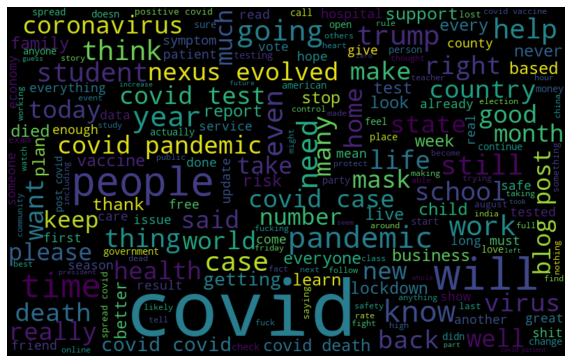

In [5]:
# Most commomly occuring words
def keywords():
    all_words = ' '.join([text for text in df_tweet['Clean_Tweet']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

keywords()

In [6]:
# Sentiment analysis using Textblob
def sentiment(tweet):

    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
df_tweet['Sentiment'] = df_tweet['Clean_Tweet'].apply(sentiment)

df_tweet.head(20)

,User_Id,Tweet_Id,Clean_Tweet,Sentiment
0,1431818420,1296884110959554560,bruh today highest number covid death state,0
1,21264229,1296884111156506624,#cityofduarte help your small business begin m...,-1
2,133604878,1296884111945211906,conservative like cost analysis covid lockdown...,1
3,1296881688253853696,1296884113866022912,please bless single mother lost covid would re...,1
4,1287874536940212224,1296884114914607104,bryce should some class when spread covid,0
5,160893804,1296884115069788160,must covid proof bunker,0
6,57150180,1296884115686514688,regardless what might think about covid people...,-1
7,577712630,1296884115829121024,open workout grader planning trying girl baske...,0
8,256463648,1296884116512743424,country worst area serco sitel paid between th...,-1
9,1276459126508466176,1296884116630183939,biden harris #followtrick blackpink selena gom...,0


In [7]:
# Querying hashtags from database
data_tags = DbConnect("SELECT Tweet_Id, Hashtag FROM TwitterEntity;")

df_tags = pd.DataFrame(columns=['Tweet_Id','Hashtags'])

for data in data_tags:
    index = len(df_tags)
    df_tags.loc[index,'Tweet_Id'] = data[0]
    df_tags.loc[index,'Hashtags'] = data[1]
    
df_tags.head(20)

,Tweet_Id,Hashtags
0,1296884111156506624,CityofDuarte
1,1296884111156506624,SmallBiz
2,1296884113866022912,WAPpartyy
3,1296884116630183939,followtrick
4,1296884117175513088,PhotoID
5,1296884117175513088,COVID19
6,1296884117175513088,vote
7,1296884117175513088,Hypocrites
8,1296884116496044033,HamOnt
9,1296884116496044033,StrongerTogether


In [8]:
# Unique hashtag counts
table = df_tags.pivot_table(index="Hashtags",values='Tweet_Id',aggfunc=len)

# Convert pivot table to dataframe
df_pivot = pd.DataFrame(table.to_records())

df_pivot.head()

,Hashtags,Tweet_Id
0,2020ESS,1
1,2020Election,1
2,2LGBTQ,1
3,6feet,1
4,7booksILove,1


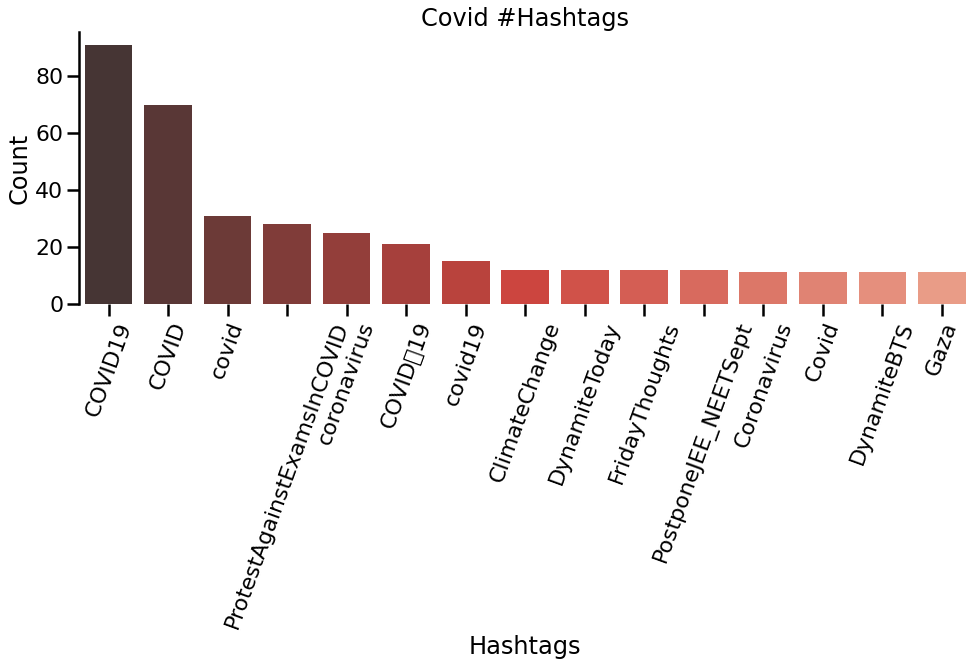

In [10]:
# Plotting hashtags counts

data = df_pivot.nlargest(columns="Tweet_Id", n = 15) 

# Creating bar graph
plt.figure(figsize=(16,5))
ax = sns.barplot(data=data, x= "Hashtags", y = "Tweet_Id", palette=("Reds_d"))

# Altering the visual elements
sns.set_context("poster")
ax.set(ylabel = 'Count')
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=70)

plt.title('Covid #Hashtags')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Output plot
plt.show()